<a href="https://colab.research.google.com/github/cronan03/NNMnist/blob/main/Lab_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Processing Sequences Using RNNs and CNNs**

# Setup

This project requires Python 3.7 or above:

In [4]:
import sys

assert sys.version_info >= (3, 7)

And TensorFlow ≥ 2.8:

In [3]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier:

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/rnn` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [6]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rnn"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [7]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

# Basic RNNs

Let's download the ridership data from the ageron/data project. It originally comes from Chicago's Transit Authority, and was downloaded from the [Chicago's Data Portal](https://homl.info/ridership).

**Warning**: in recent Keras versions, `get_file()` now wraps the extracted directory inside a directory whose name ends with `_extracted`, so the following code checks for that:

In [8]:
filepath = tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)
if "_extracted" in filepath:
    ridership_path = Path(filepath) / "ridership"
else:
    ridership_path = Path(filepath).with_name("ridership")

108512/108512 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership_extracted/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [13]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


1.date: The service date.
2.day_type: Indicates the type of day: 'W' for Weekday, 'A' for Saturday, and 'U' for Sunday/Holiday.
3.bus: Number of bus boardings.
4.rail: Number of rail (train) boardings.

Let's look at the first few months of 2019 (note that Pandas treats the range boundaries as inclusive):

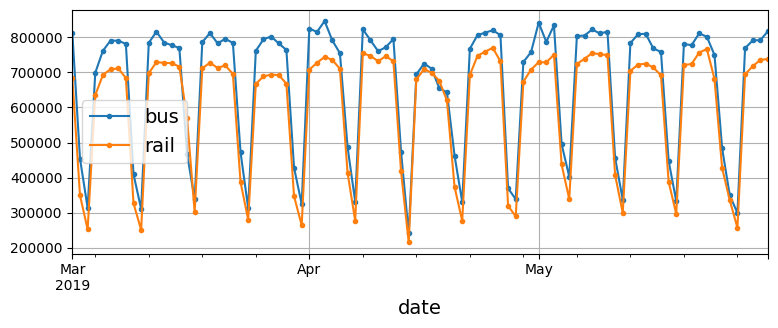

In [14]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
save_fig("daily_ridership_plot")  # extra code – saves the figure for the book
plt.show()

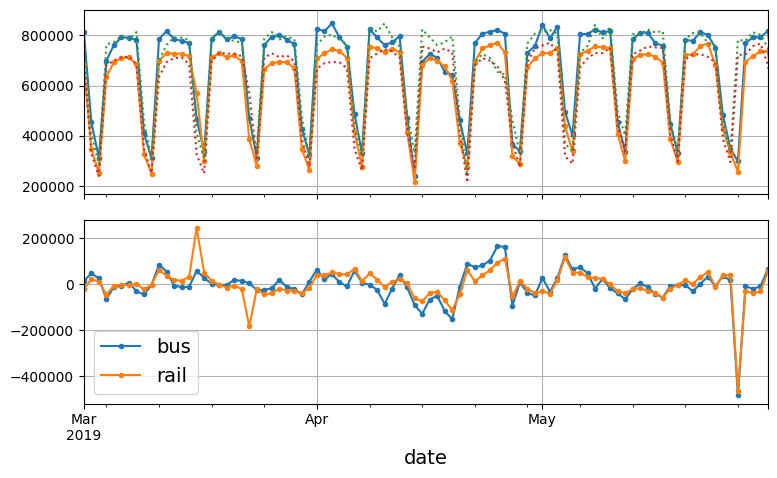

In [15]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
save_fig("differencing_plot")  # extra code – saves the figure for the book
plt.show()

Top Plot has dotted lines which are the original plot shifted by 7 days.
Bottom Plot is the 7-day difference plot.

In [16]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

Mean absolute error (MAE), also called mean absolute deviation (MAD):

In [17]:
diff_7.abs().mean()

,0
bus,43915.608696
rail,42143.271739


Mean absolute percentage error (MAPE):

In [18]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

,0
bus,0.082938
rail,0.089948


Now let's look at the yearly seasonality and the long-term trends:

**Warning**: Pandas' API to compute the mean for each month has changed quite a bit, so the code below tries the newest API, and falls back to an older API, and if that also fails, it falls back to the code in the book.

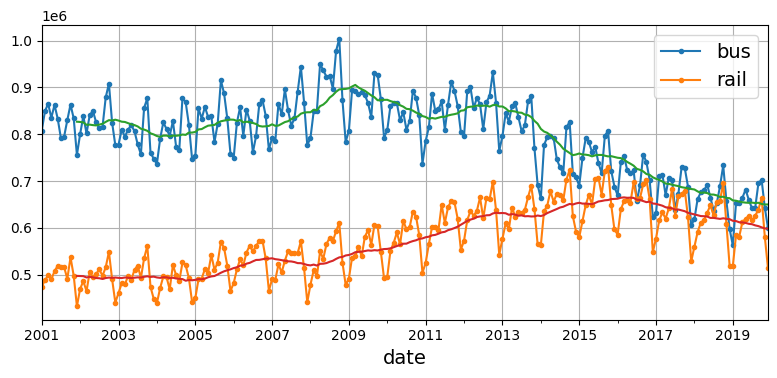

In [19]:
period = slice("2001", "2019")
try:
    df_monthly = df.select_dtypes(include="number").resample('ME').mean()  # compute the mean for each month
    rolling_average_12_months = df_monthly.loc[period].rolling(window=12).mean()
except ValueError as ex:
    try:
        df_monthly = df.select_dtypes(include="number").resample('M').mean()  # compute the mean for each month
        rolling_average_12_months = df_monthly.loc[period].rolling(window=12).mean()
    except ValueError as ex:
        df_monthly = df.resample('M').mean()  # compute the mean for each month
        rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
save_fig("long_term_ridership_plot")  # extra code – saves the figure for the book
plt.show()

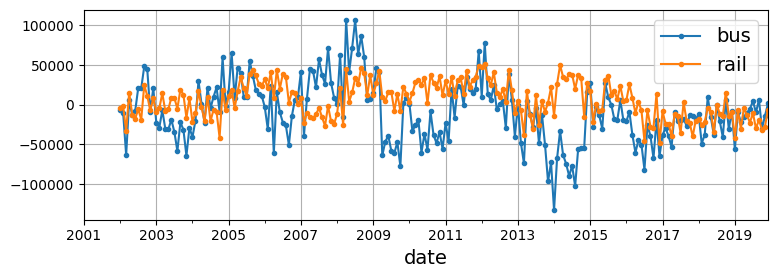

In [20]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
save_fig("yearly_diff_plot")  # extra code – saves the figure for the book
plt.show()

If running on Colab or Kaggle, install the statsmodels library:

In [21]:
if "google.colab" in sys.modules:
    %pip install -q -U statsmodels

AutoRegressive Integrated Moving Average to forecast a timeseries.


In [22]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")#The 'rail' column is selected from the DataFrame df within the specified date range.
#The .asfreq("D") method ensures that the time series has a daily frequency, filling in any missing dates as necessary.
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()  # returns 427,758.6

**More details on ARIMA**

order Parameter: This tuple (p, d, q) specifies the non-seasonal components of the ARIMA model:
p = 1: The number of lag observations included in the model (autoregressive part).
d = 0: The number of times the raw observations are differenced to make the time series stationary. A value of 0 indicates that differencing is not applied.
q = 0: The size of the moving average window.
seasonal_order Parameter: This tuple (P, D, Q, S) defines the seasonal components:
P = 0: The autoregressive order for the seasonal component.
D = 1: The number of seasonal differences applied to the series.
Q = 1: The moving average order for the seasonal component.
S = 7: The periodicity (seasonal cycle length), indicating a weekly seasonality.

In [23]:
y_pred[0]  # ARIMA forecast

<ipython-input-23-0c8da231e770>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred[0]  # ARIMA forecast


427758.62641035335

In [24]:
df["rail"].loc["2019-06-01"]  # target value

379044

In [25]:
df["rail"].loc["2019-05-25"]  # naive forecast (value from one week earlier)

426932

**Warning**: Accessing Pandas `Series` by index directly is deprecated, so I replaced `model.forecast()[0]` with `model.forecast().iloc[0]`:

In [26]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast().iloc[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  # returns 32,040.7

In [27]:
mae

32040.720089453378

<ipython-input-28-13720d581ff0>:4: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")


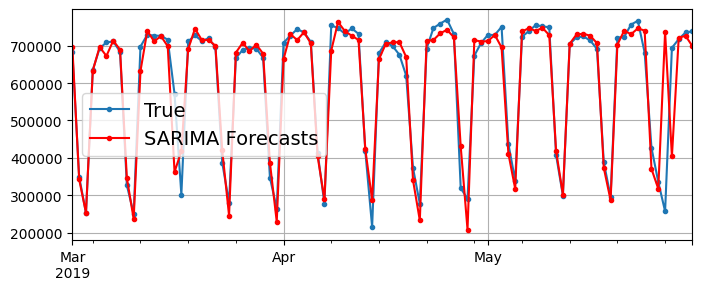

In [28]:
# extra code – displays the SARIMA forecasts
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

The following code demonstrates how to create a time series dataset using TensorFlow's tf.keras.utils.timeseries_dataset_from_array function.

In [29]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
'''
The following function converts the my_series data into a dataset of sliding windows. Let's break down the parameters:
data: The input data for the sequences, which is my_series in this case.
targets: The target values corresponding to each sequence. Here, it's my_series[3:], meaning the targets start from the fourth element, effectively shifting the targets 3 steps ahead.
sequence_length: The length of each input sequence. With a value of 3, each sequence will consist of 3 consecutive elements from my_series.
batch_size: The number of sequences per batch. Set to 2, so the dataset will yield batches containing 2 sequences each.
'''
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

The following code snippet demonstrates how to create overlapping windows from a range of integers using TensorFlow's tf.data.Dataset

In [30]:
'''
tf.data.Dataset.range(6) : This line generates a dataset containing integers from 0 to 5.
.window(4, shift=1) : The window method segments the dataset into overlapping windows.
Each window is a sub-dataset containing 4 consecutive elements.
The shift=1 parameter specifies that each window starts one element after the previous one, creating overlapping windows.
'''


for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [31]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [32]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [33]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

Before we continue looking at the data, let's split the time series into three periods, for training, validation and testing. We won't look at the test data for now:

In [34]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [35]:
seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [36]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0594 - mae: 0.2725 - val_loss: 0.0122 - val_mae: 0.1206
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0108 - mae: 0.1142 - val_loss: 0.0115 - val_mae: 0.1218
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0106 - mae: 0.1118 - val_loss: 0.0096 - val_mae: 0.1087
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0081 - mae: 0.0965 - val_loss: 0.0084 - val_mae: 0.0985
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0078 - mae: 0.0943 - val_loss: 0.0077 - val_mae: 0.0927
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0078 - mae: 0.0910 - val_loss: 0.0082 - val_mae: 0.0925
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0078 - mae: 0.0912 - val_loss: 0.0068 - val_mae: 0.0844
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0061 - mae: 0.0814 - val_loss: 0.0071 - val_mae: 0.0851
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.00

In [37]:
# extra code – evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0020 - mae: 0.0392


37934.813648462296

## Using a Simple RNN

In [38]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [39]:
# extra code – defines a utility function we'll reuse several time

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [40]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0170 - mae: 0.1629 - val_loss: 0.0167 - val_mae: 0.1462
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0166 - mae: 0.1613 - val_loss: 0.0165 - val_mae: 0.1603
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0167 - mae: 0.1650 - val_loss: 0.0165 - val_mae: 0.1534
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0165 - mae: 0.1643 - val_loss: 0.0164 - val_mae: 0.1536
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0165 - mae: 0.1634 - val_loss: 0.0164 - val_mae: 0.1558
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0166 - mae: 0.1650 - val_loss: 0.0165 - val_mae: 0.1505
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0170 - mae: 0.1662 - val_loss: 0.0164 - val_mae: 0.1555
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0164 - mae: 0.1638 - val_loss: 0.0170 - val_mae: 0.1406
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.01

102795.25071382523

This code constructs a Sequential model with two layers:

SimpleRNN Layer:

units=32: Specifies that the RNN layer has 32 units (neurons). Each unit processes input sequences and maintains a hidden state that captures temporal dependencies.
input_shape=[None, 1]: Indicates that the input will have an unspecified number of time steps (None) with one feature per time step. This setup is typical for univariate time series data.
Dense Layer:

units=1: This fully connected layer outputs a single value. By default, it uses a linear activation function, making it suitable for regression tasks.

In [41]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [42]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0790 - mae: 0.3117 - val_loss: 0.0149 - val_mae: 0.1614
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0094 - mae: 0.1048 - val_loss: 0.0039 - val_mae: 0.0640
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0044 - mae: 0.0642 - val_loss: 0.0019 - val_mae: 0.0387
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0037 - mae: 0.0562 - val_loss: 0.0032 - val_mae: 0.0576
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - mae: 0.0547 - val_loss: 0.0027 - val_mae: 0.0461
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mae: 0.0524 - val_loss: 0.0021 - val_mae: 0.0389
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mae: 0.0498 - val_loss: 0.0027 - val_mae: 0.0540
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mae: 0.0560 - val_loss: 0.0023 - val_mae: 0.0376
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0

30974.68428313732

## Deep RNNs

units=32: Specifies that the RNN layer has 32 units (neurons).
return_sequences=True: Ensures that the layer returns the full sequence of outputs for each input sequence, not just the last output. This is necessary when stacking RNN layers so that the subsequent layer receives the entire sequence as input.
KERAS
input_shape=[None, 1]: Indicates that the input will have an unspecified number of time steps (None) with one feature per time step.

In [43]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
#Returns only the last output in the sequence, which is then passed to the Dense layer.
    tf.keras.layers.Dense(1)
])

In [44]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0640 - mae: 0.2772 - val_loss: 0.0123 - val_mae: 0.1412
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0085 - mae: 0.0941 - val_loss: 0.0035 - val_mae: 0.0627
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0048 - mae: 0.0688 - val_loss: 0.0048 - val_mae: 0.0785
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0050 - mae: 0.0648 - val_loss: 0.0031 - val_mae: 0.0554
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0042 - mae: 0.0592 - val_loss: 0.0022 - val_mae: 0.0412
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0038 - mae: 0.0562 - val_loss: 0.0027 - val_mae: 0.0491
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0042 - mae: 0.0599 - val_loss: 0.0022 - val_mae: 0.0401
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0037 - mae: 0.0550 - val_loss: 0.0019 - val_mae: 0.0342
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - lo

27310.961857438087

## Multivariate Time Series
A multivariate time series is a sequence of data points where each point in time is associated with multiple variables or features that are measured simultaneously. In other words, it's like having multiple time series happening at the same time, and these series can be related to each other.

**Warning**: in recent Pandas versions, `get_dummies()` returns booleans instead of floats, so I added `dtype=float` to ensure we get floats.

In [45]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar, dtype=float)  # one-hot encode the day type

In [46]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [47]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [48]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [49]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 0.0309 - mae: 0.1840 - val_loss: 0.0055 - val_mae: 0.0835
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0053 - mae: 0.0823 - val_loss: 6.9976e-04 - val_mae: 0.0268
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0024 - mae: 0.0510 - val_loss: 9.4928e-04 - val_mae: 0.0342
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0015 - mae: 0.0389 - val_loss: 0.0014 - val_mae: 0.0430
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0015 - mae: 0.0380 - val_loss: 7.6102e-04 - val_mae: 0.0292
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - mae: 0.0366 - val_loss: 7.9378e-04 - val_mae: 0.0302
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0012 - mae: 0.0353 - val_loss: 6.5403e-04 - val_mae: 0.0256
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014 - mae: 0.0388 - val_loss: 6.2462e-04 - val_mae: 0.0248
Epoch 9/500
33/33 ━━━━━━━━━━━━━

22977.184504270554

In [50]:
# extra code – build and train a multitask RNN that forecasts both bus and rail

tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0931 - mae: 0.3245 - val_loss: 0.0108 - val_mae: 0.1288
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0061 - mae: 0.0814 - val_loss: 0.0016 - val_mae: 0.0396
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0551 - val_loss: 0.0025 - val_mae: 0.0567
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0531 - val_loss: 0.0013 - val_mae: 0.0378
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mae: 0.0499 - val_loss: 0.0015 - val_mae: 0.0410
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0024 - mae: 0.0488 - val_loss: 0.0011 - val_mae: 0.0354
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - mae: 0.0496 - val_loss: 0.0011 - val_mae: 0.0342
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022 - mae: 0.0466 - val_loss: 0.0013 - val_mae: 0.0384
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - mae: 

26141.414418816566

In [51]:
# extra code – evaluates the naive forecasts for bus
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

43441.63157894738

In [52]:
# extra code – evaluates the multitask RNN's forecasts both bus and rail
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * tf.keras.metrics.MeanAbsoluteError()(
        mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
    print(name, int(mae))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
bus 27085
rail 25197


## Forecasting Several Steps Ahead

In [53]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


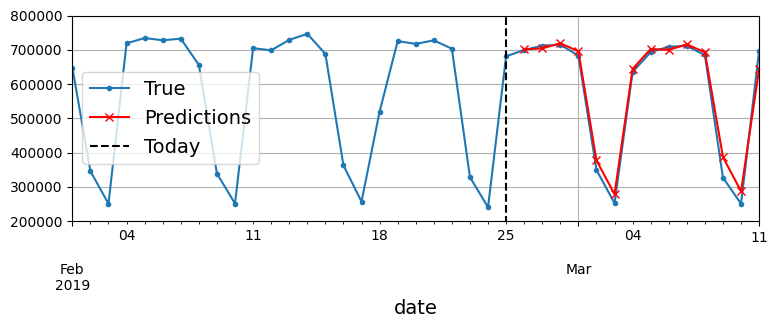

In [54]:
# extra code – generates and saves Figure 15–11

# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
save_fig("forecast_ahead_plot")
plt.show()

Now let's create an RNN that predicts all 14 next values at once:

In [55]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [56]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [57]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.1926 - mae: 0.5012 - val_loss: 0.0311 - val_mae: 0.1926
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0271 - mae: 0.1871 - val_loss: 0.0176 - val_mae: 0.1491
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0177 - mae: 0.1515 - val_loss: 0.0136 - val_mae: 0.1271
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0145 - mae: 0.1379 - val_loss: 0.0112 - val_mae: 0.1172
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0123 - mae: 0.1258 - val_loss: 0.0098 - val_mae: 0.1080
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0110 - mae: 0.1180 - val_loss: 0.0084 - val_mae: 0.0991
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0099 - mae: 0.1093 - val_loss: 0.0074 - val_mae: 0.0947
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - mae: 0.1030 - val_loss: 0.0069 - val_mae: 0.0874
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.

34484.93778705597

In [58]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


Now let's create an RNN that predicts the next 14 steps at each time step. That is, instead of just forecasting time steps 56 to 69 based on time steps 0 to 55, it will forecast time steps 1 to 14 at time step 0, then time steps 2 to 15 at time step 1, and so on, and finally it will forecast time steps 56 to 69 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

To prepare the datasets, we can use `to_windows()` twice, to get sequences of consecutive windows, like this:

In [59]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])>]

Then we can split these elements into the desired inputs and targets:

In [60]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]])>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]])>)]

Let's wrap this idea into a utility function. It will also take care of shuffling (optional) and batching:

In [61]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(
        lambda S: (S[:, 0], S[:, 1:, target_col]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [62]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [63]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [64]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/500
     33/Unknown 3s 30ms/step - loss: 0.1263 - mae: 0.3850

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.1245 - mae: 0.3814 - val_loss: 0.0169 - val_mae: 0.1360
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0126 - mae: 0.1223 - val_loss: 0.0096 - val_mae: 0.0992
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0083 - mae: 0.0932 - val_loss: 0.0071 - val_mae: 0.0833
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0066 - mae: 0.0812 - val_loss: 0.0064 - val_mae: 0.0784
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0057 - mae: 0.0736 - val_loss: 0.0056 - val_mae: 0.0723
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0051 - mae: 0.0693 - val_loss: 0.0050 - val_mae: 0.0664
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0049 - mae: 0.0672 - val_loss: 0.0054 - val_mae: 0.0707
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0047 - mae: 0.0647 - val_loss: 0.0048 - val_mae: 0.0653
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0045 -

46633.73902440071

In [65]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]  # only the last time step's output

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


In [66]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

      1/Unknown 0s 299ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step
MAE for +1: 24,584
MAE for +2: 28,102
MAE for +3: 31,214
MAE for +4: 33,465
MAE for +5: 32,413
MAE for +6: 35,537
MAE for +7: 34,527
MAE for +8: 34,845
MAE for +9: 36,959
MAE for +10: 32,365
MAE for +11: 35,749
MAE for +12: 37,382
MAE for +13: 37,423
MAE for +14: 34,440


Look up about Teacher Forcing and Curriculum Learning

# Deep RNNs with Layer Norm
Layer Normalization is a technique used to normalize the activations of neurons within a layer. Unlike batch normalization, which normalizes across a batch of samples, LayerNorm normalizes across the features (neurons) in a single layer.

Layer Normalization can be a valuable addition to Deep RNNs. It helps to address gradient problems, accelerates training, reduces initialization sensitivity, and potentially improves generalization. By using LayerNorm, you can build deeper and more stable RNNs for complex sequence modeling tasks.

In [67]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                             activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [68]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Just training for 5 epochs to show that it works (you can increase this if you want):

In [69]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.1440 - mae: 0.3890 - val_loss: 0.0195 - val_mae: 0.1564
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0165 - mae: 0.1490 - val_loss: 0.0156 - val_mae: 0.1295
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0128 - mae: 0.1319 - val_loss: 0.0137 - val_mae: 0.1191
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0113 - mae: 0.1212 - val_loss: 0.0123 - val_mae: 0.1121
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0104 - mae: 0.1143 - val_loss: 0.0115 - val_mae: 0.1054
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0124 - mae: 0.1088


105378.8959980011

# LSTMs

In [70]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [71]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1110 - mae: 0.3852 - val_loss: 0.0190 - val_mae: 0.1604
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0179 - mae: 0.1659 - val_loss: 0.0179 - val_mae: 0.1441
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0157 - mae: 0.1528 - val_loss: 0.0169 - val_mae: 0.1431
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0151 - mae: 0.1501 - val_loss: 0.0164 - val_mae: 0.1400
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0144 - mae: 0.1454 - val_loss: 0.0158 - val_mae: 0.1372
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0166 - mae: 0.1396


137226.50706768036

# GRUs

In [72]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [73]:
fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0992 - mae: 0.3657 - val_loss: 0.0169 - val_mae: 0.1573
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0157 - mae: 0.1442 - val_loss: 0.0142 - val_mae: 0.1316
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0126 - mae: 0.1300 - val_loss: 0.0131 - val_mae: 0.1268
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0118 - mae: 0.1261 - val_loss: 0.0124 - val_mae: 0.1224
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0111 - mae: 0.1208 - val_loss: 0.0120 - val_mae: 0.1188
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0128 - mae: 0.1220


118775.74026584625

## Using One-Dimensional Convolutional Layers to Process Sequences
Captures both local and global patterns.
Reduces computational burden by downsampling.
Performs feature engineering automatically.
Potentially improves the performance of sequence-to-sequence tasks.

```
  |-----0-----|      |-----3----|      |--... |-------52------|
         |-----1----|      |-----4----|   ... |       |-------53------|
               |-----2----|     |------5--...-51------|       |-------54------|
X:  0  1  2  3  4  5  6  7  8  9 10 11 12 ...  104 105 106 107 108 109 110 111
Y:      from 4     6     8    10    12    ...      106     108     110     112
         to 17    19    21    23    25    ...      119     121     123     125
```

In [74]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                       shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Just training for 5 epochs to show that it works (you can increase this if you want):

In [75]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
     31/Unknown 2s 12ms/step - loss: 0.1018 - mae: 0.3704

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.1003 - mae: 0.3668 - val_loss: 0.0188 - val_mae: 0.1641
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0169 - mae: 0.1542 - val_loss: 0.0162 - val_mae: 0.1383
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0138 - mae: 0.1405 - val_loss: 0.0150 - val_mae: 0.1303
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0125 - mae: 0.1317 - val_loss: 0.0139 - val_mae: 0.1243
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0115 - mae: 0.1237 - val_loss: 0.0129 - val_mae: 0.1191
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0129 - mae: 0.1191


119130.85728883743

## WaveNet

```
 ⋮
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\...
   \  /  \  /  \  /  \  /  \  /  \  /  \     
     /    \      /    \      /    \          
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /...\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 111
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 112
 /14 15 16 17 18 19 20 21 22  23 24 25 26 ... 125
```

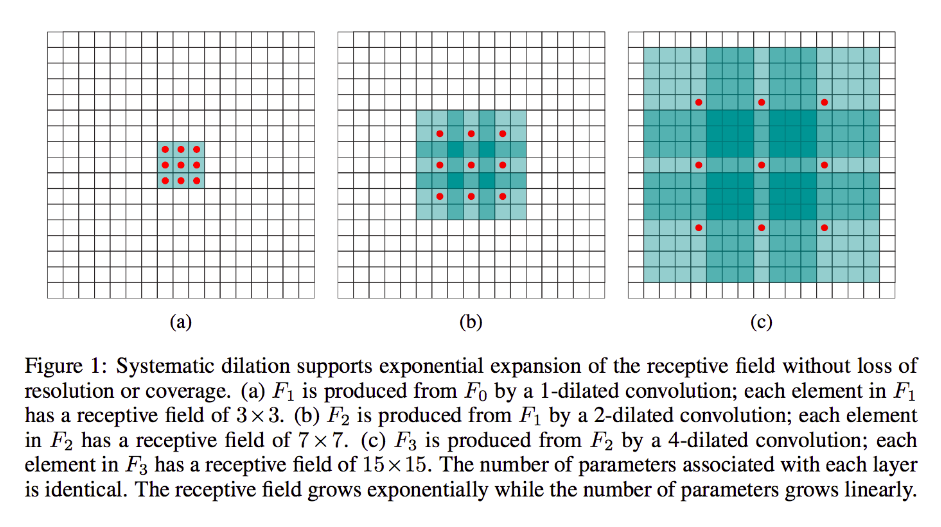

In [76]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Just training for 5 epochs to show that it works (you can increase this if you want):

In [77]:
fit_and_evaluate(wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.1384 - mae: 0.4617 - val_loss: 0.0218 - val_mae: 0.1630
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0175 - mae: 0.1600 - val_loss: 0.0185 - val_mae: 0.1542
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0159 - mae: 0.1574 - val_loss: 0.0183 - val_mae: 0.1516
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0154 - mae: 0.1552 - val_loss: 0.0179 - val_mae: 0.1499
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0150 - mae: 0.1526 - val_loss: 0.0171 - val_mae: 0.1456
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0171 - mae: 0.1456


145587.57841587067

# Extra Material – Wavenet Implementation

Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [78]:
class GatedActivationUnit(tf.keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = tf.keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [79]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = tf.keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = tf.keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return tf.keras.layers.Add()([z, inputs]), z

In [80]:
tf.random.set_seed(42)

n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 32  # 128 in the paper
n_outputs = 14  # 256 in the paper

inputs = tf.keras.layers.Input(shape=[None, 5])
z = tf.keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)

z = tf.keras.activations.relu(tf.keras.layers.Add()(skip_to_last))
z = tf.keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_preds = tf.keras.layers.Conv1D(n_outputs, kernel_size=1)(z)

full_wavenet_model = tf.keras.Model(inputs=[inputs], outputs=[Y_preds])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [81]:
fit_and_evaluate(full_wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_83']
Received: inputs=Tensor(shape=(None, None, 5))
  warnings.warn(msg)


31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 0.1362 - mae: 0.4480 - val_loss: 0.0194 - val_mae: 0.1560
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - loss: 0.0157 - mae: 0.1468 - val_loss: 0.0150 - val_mae: 0.1271
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0113 - mae: 0.1225 - val_loss: 0.0120 - val_mae: 0.1118
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0091 - mae: 0.1076 - val_loss: 0.0103 - val_mae: 0.1024
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0076 - mae: 0.0948 - val_loss: 0.0088 - val_mae: 0.0938
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0088 - mae: 0.0938


93810.72968244553

In this lab we explored the fundamentals of RNNs and used them to process sequences (namely, time series). In the process we also looked at other ways to process sequences, including CNNs.